In [108]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [15]:
# hyperparams
num_classes = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])


dataset_train = datasets.CIFAR10('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.CIFAR10('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
dataset_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

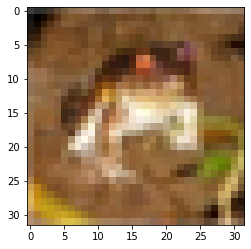

In [18]:
import matplotlib.pyplot as plt

plt.imshow(dataset_train.data[0])
plt.show()

In [19]:
class ResBlock(nn.Module):

    def __init__(self, input_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(input_planes, planes, stride=stride, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, stride=1, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(planes)
        self.activ= nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self,x):

        origin_x = x

        output = self.conv1(x)
        output = self.bn1(output)
        output = self.activ(output)
        output = self.conv2(output)
        output = self.bn2(output)

        if self.downsample is not None:
            origin_x = self.downsample(origin_x)
        
        output += origin_x
        output = self.activ(output)

        return output


class ResNet(nn.Module):
    def __init__(self, block, num_layers, classes=10):
        super().__init__()

        self.input_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.activ= nn.ReLU(inplace=True) 

        self.layer1 = self._layer(block, 64, num_layers[0], stride=1)
        self.layer2 = self._layer(block, 128, num_layers[1], stride=2)
        self.layer3 = self._layer(block, 256, num_layers[2], stride=2)
        self.layer4 = self._layer(block, 512, num_layers[3], stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=4, stride=1)
        self.fc = nn.Linear(512, classes)
    
    def _layer(self, block, planes, num_layers, stride=1):
        downsample = None
        if stride!=1 or planes != self.input_planes:
            downsample = nn.Sequential(nn.Conv2d(self.input_planes,planes,kernel_size=1,stride=stride),
                                       nn.BatchNorm2d(planes))
        netLayers =[]
        netLayers.append(block(self.input_planes, planes, stride=stride, downsample=downsample))
        self.input_planes = planes
        for i in range(1, num_layers):
            netLayers.append(block(self.input_planes,planes))
        
        return nn.Sequential(*netLayers)

    def forward(self,x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activ(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)

        return x

In [20]:
ResNet18 = ResNet(ResBlock, num_layers=[2,2,2,2], classes=10)

ResNet18.to(device)
optim = torch.optim.Adam(ResNet18.parameters())
loss_func = nn.CrossEntropyLoss()

In [21]:
from sklearn.metrics import accuracy_score

In [94]:
losses = []
losses_test = []
accuracy = 0
max_accuracy = 0
print(device)

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        
        predict = ResNet18(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        losses.append(loss.item())
        # print(losses)
        loss.backward()
        optim.step()
        if i % 100 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

    #test model
    for i, batch in enumerate(testloader):
        inputs, labels = batch

        ResNet18.eval()
        loss_test = 0
        with torch.no_grad():
            predict = ResNet18(inputs.to(device))
            loss_test += loss_func(predict, labels.to(device))
            # losses_test.append(loss_test.item())
            losses_test.append(loss_func(predict, labels.to(device)).item())
            
            accuracy = accuracy_score(labels.cpu(), predict.cpu().argmax(axis=1))
            if accuracy > max_accuracy:
              max_accuracy = accuracy
              torch.save(ResNet18.state_dict(), f'./best_by_accuracy.pth')


    ResNet18.train()
    print('test loss:', loss_test / i)

    #save every epoch
    torch.save(ResNet18.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')

cuda:0
epoch: 0, step: 0, loss: 0.02518835850059986
epoch: 0, step: 100, loss: 0.048689186573028564
epoch: 0, step: 200, loss: 0.06526634842157364
epoch: 0, step: 300, loss: 0.10541447252035141
test loss: tensor(0.0100, device='cuda:0')
epoch: 1, step: 0, loss: 0.0246316846460104
epoch: 1, step: 100, loss: 0.0749460756778717
epoch: 1, step: 200, loss: 0.05843706429004669
epoch: 1, step: 300, loss: 0.029254915192723274
test loss: tensor(0.0095, device='cuda:0')
epoch: 2, step: 0, loss: 0.04033872112631798
epoch: 2, step: 100, loss: 0.10384427011013031
epoch: 2, step: 200, loss: 0.05251597240567207
epoch: 2, step: 300, loss: 0.03768862783908844
test loss: tensor(0.0089, device='cuda:0')
epoch: 3, step: 0, loss: 0.05001961812376976
epoch: 3, step: 100, loss: 0.03281961753964424
epoch: 3, step: 200, loss: 0.04649030417203903
epoch: 3, step: 300, loss: 0.02596125565469265
test loss: tensor(0.0143, device='cuda:0')
epoch: 4, step: 0, loss: 0.028497055172920227
epoch: 4, step: 100, loss: 0.00

2е обучение

In [97]:
max_accuracy

0.921875

In [110]:
losses = np.array(losses) 
losses_test = np.array(losses_test) 
np.save('losses', losses)
np.save('losses_test', losses_test)

In [105]:
losses_resized = []  # для согласованного отображения loss графиков теста и обучения, число отображаемых шагов для обучения сжато путём усреднения по пятёркам значений loss функций
i = 0
while i < 3900:
  losses_resized.append(losses[i: i+5].mean())
  i = i+5

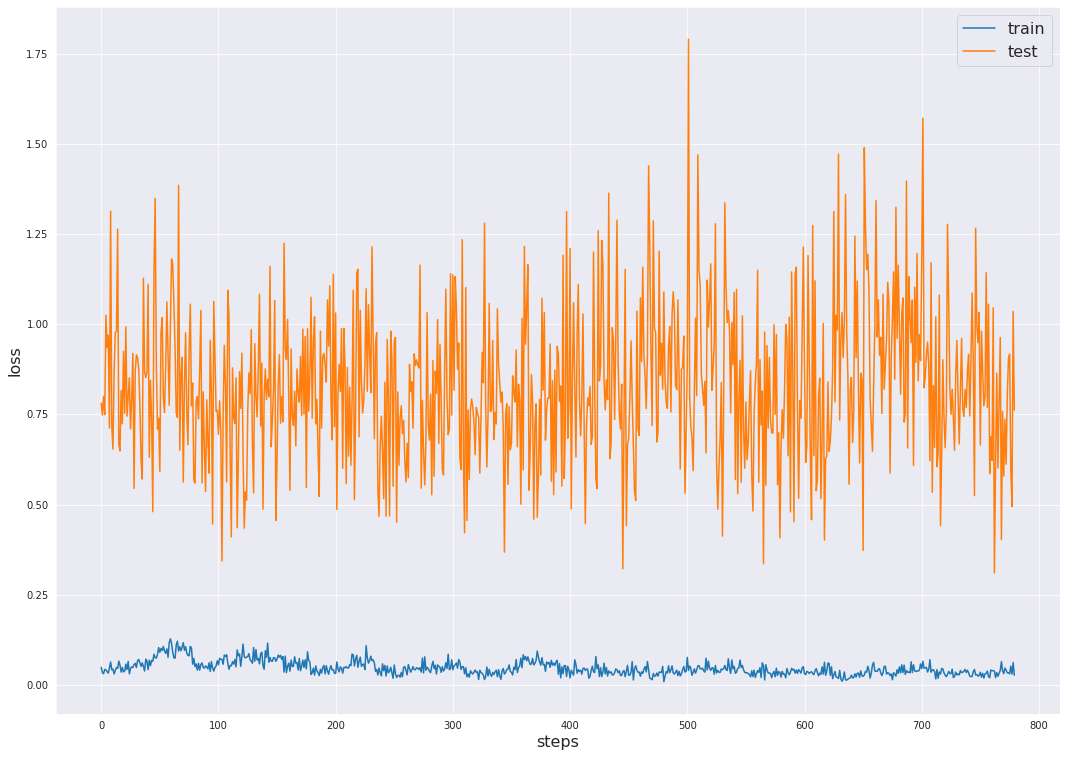

In [107]:
steps = [i for i in range(n_epochs*len(testloader))]

plt.figure(figsize=(18, 13))
plt.plot(steps, losses_resized, label='train')
plt.plot(steps, losses_test, label='test')
plt.xlabel('steps', size=16)
plt.ylabel('loss', size=16)
plt.legend(fontsize=16);

1е обучение

In [30]:
max_accuracy # с 1го обучения

0.921875

In [70]:
import numpy as np

np.array(losses) 
np.array(losses_test) 

np.save('losses', losses)
np.save('losses_test', losses_test)

In [ ]:
losses = np.load('losses.npy', allow_pickle=True)
losses

In [ ]:
losses_test = np.load('losses_test.npy', allow_pickle=True)
losses_test

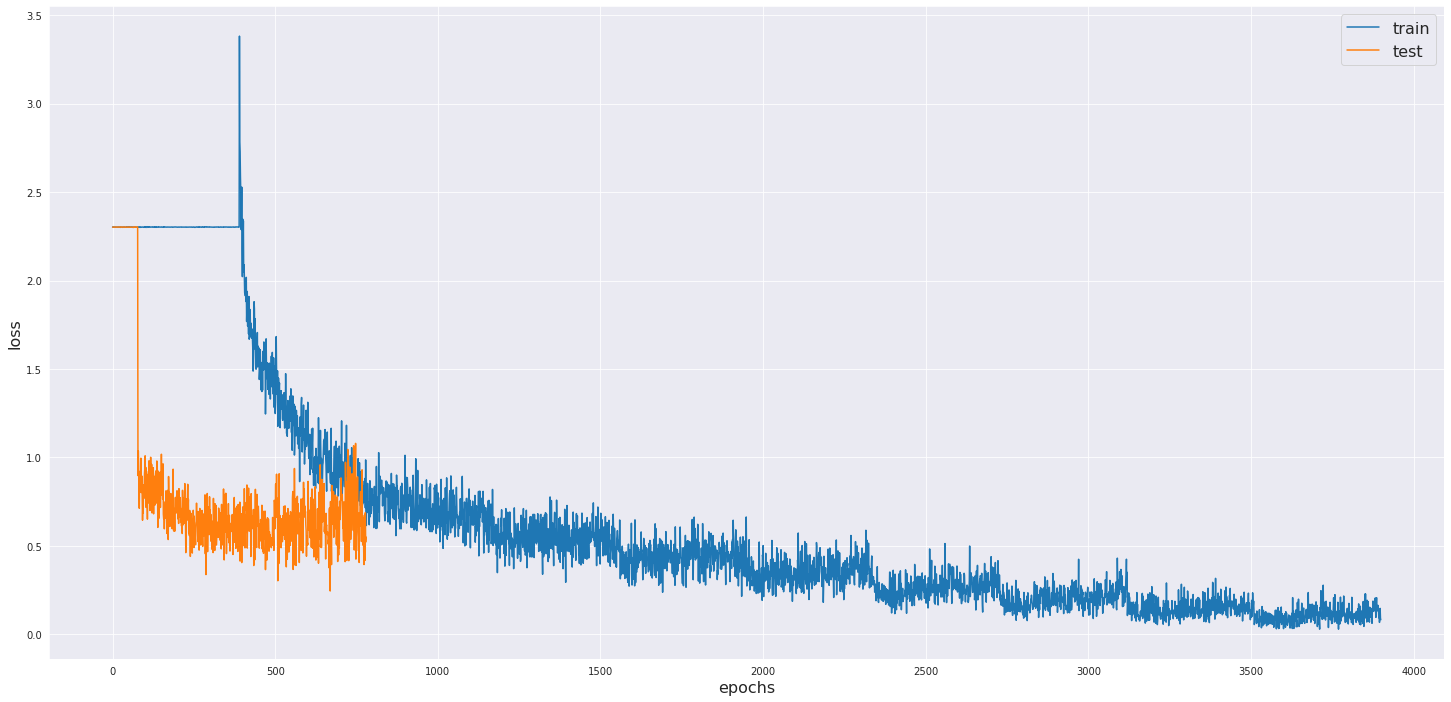

In [76]:
import seaborn as sns
from seaborn import set_style
set_style('darkgrid')
steps_train = [i for i in range(n_epochs*len(trainloader))]
steps_test = [i for i in range(n_epochs*len(testloader))]
plt.figure(figsize=(25, 12))
plt.plot(steps_train, losses, label='train')
plt.plot(steps_test, losses_test, label='test')
plt.xlabel('epochs', size=16)
plt.ylabel('loss', size=16)
plt.legend(fontsize=16);

In [89]:
losses_resized = []
i = 0
while i < 3900:
  losses_resized.append(losses[i: i+5].mean())
  i = i+5

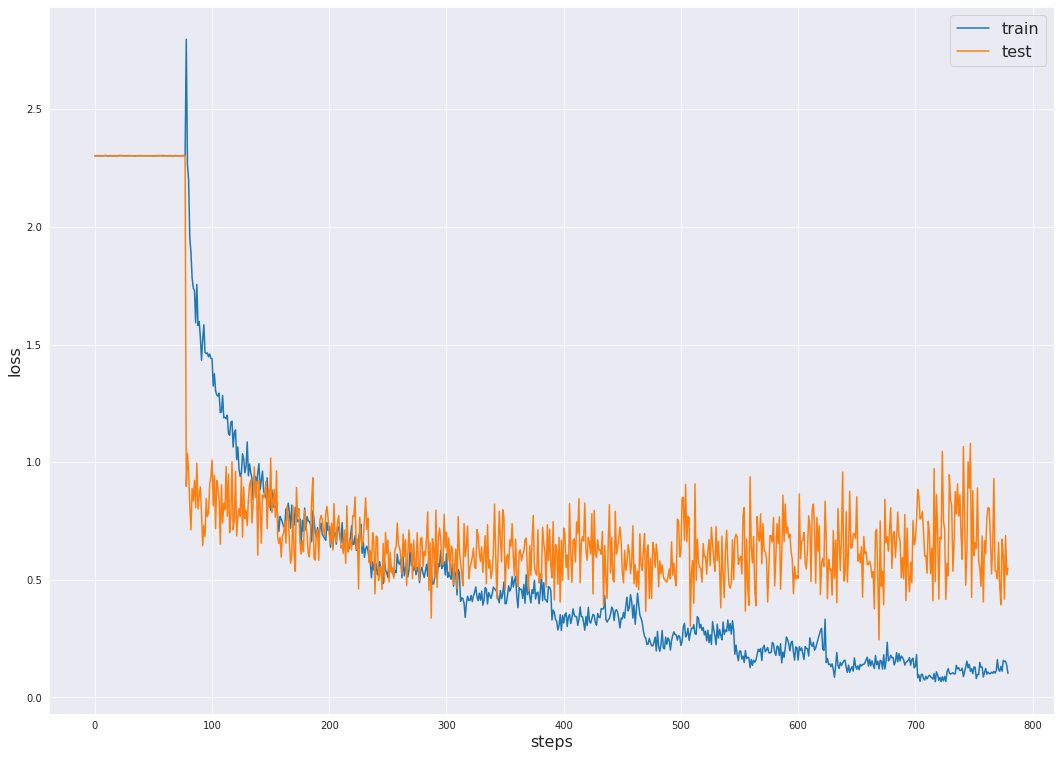

In [91]:
steps = [i for i in range(n_epochs*len(testloader))]

plt.figure(figsize=(18, 13))
plt.plot(steps, losses_resized, label='train')
plt.plot(steps, losses_test, label='test')
plt.xlabel('epochs', size=16)
plt.ylabel('loss', size=16)
plt.legend(fontsize=16);

In [ ]:
# 1е успешное обучение
losses = []
losses_test = []
accuracy = 0
max_accuracy = 0
print(device)

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        
        predict = ResNet18(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        losses.append(loss.item())
        # print(losses)
        loss.backward()
        optim.step()
        if i % 100 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

    #test model
    for i, batch in enumerate(testloader):
        inputs, labels = batch

        ResNet18.eval()
        loss_test = 0
        with torch.no_grad():
            predict = ResNet18(inputs.to(device))
            # loss_test += loss_func(predict, labels.to(device))
            # losses_test.append(loss_test.item())
            losses_test.append(loss_func(predict, labels.to(device)).item())
            
            accuracy = accuracy_score(labels.cpu(), predict.cpu().argmax(axis=1))
            if accuracy > max_accuracy:
              max_accuracy = accuracy
              torch.save(ResNet18.state_dict(), f'./best_by_accuracy.pth')


    ResNet18.train()
    print('test loss:', loss_test / i)

    #save every epoch
    torch.save(ResNet18.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')

cuda:0
epoch: 0, step: 0, loss: 2.302583694458008
epoch: 0, step: 100, loss: 2.3047804832458496
epoch: 0, step: 200, loss: 2.3026840686798096
epoch: 0, step: 300, loss: 2.302952527999878
test loss: tensor(0.0299, device='cuda:0')
epoch: 1, step: 0, loss: 3.38230299949646
epoch: 1, step: 100, loss: 1.4082105159759521
epoch: 1, step: 200, loss: 0.9628133177757263
epoch: 1, step: 300, loss: 0.9139971733093262
test loss: tensor(0.0125, device='cuda:0')
epoch: 2, step: 0, loss: 0.6151576638221741
epoch: 2, step: 100, loss: 0.6552124619483948
epoch: 2, step: 200, loss: 0.7113577723503113
epoch: 2, step: 300, loss: 0.7042445540428162
test loss: tensor(0.0099, device='cuda:0')
epoch: 3, step: 0, loss: 0.5019964575767517
epoch: 3, step: 100, loss: 0.48132139444351196
epoch: 3, step: 200, loss: 0.523138701915741
epoch: 3, step: 300, loss: 0.5224903225898743
test loss: tensor(0.0081, device='cuda:0')
epoch: 4, step: 0, loss: 0.4586023986339569
epoch: 4, step: 100, loss: 0.33834415674209595
epoch: